In [1]:
import numpy as np

# K Nearest Neighbors

In [38]:
def euclidean_distance(x, y):
    """Compute euclidean distance"""
    return np.linalg.norm(x-y, 2)

class KNN(object):
    """ Super class of KNN classifier and KNN Regressor
    Parameters
    ----------
    k: int
        Number of nearest neighbors to be used
    """
    def __init__(self, k=5):
        self.k = k
    
    def predict(self, x_test, x_train, y_train):
        """ Get output of KNN"""
        y_pred = np.empty(x_test.shape[0])
        for i, sample in enumerate(x_test):
            # Find distance to all training points and find the k-nearest ones
            k_nearest_idx = np.argsort([euclidean_distance(sample, training_data) for training_data in x_train])[:self.k]
            # Extract the labels of the K nearest neighboring training samples
            k_nearest_neighbors = np.array([y_train[j] for j in k_nearest_idx])
            # Get y labels of k nearest points
            y_pred[i] = self._get_aggregated_output(k_nearest_neighbors)
        return y_pred

In [39]:
class KNNClassifier(KNN):
    """ KNN classifier
    (Defines the majority vote function)
    """
    def _majority_vote(self, neighbor_labels):
        counts = np.bincount(neighbor_labels.astype("int"))
        return counts.argmax()

    def predict(self, x_test, x_train, y_train):
        self._get_aggregated_output = self._majority_vote
        return super(KNNClassifier, self).predict(x_test, x_train, y_train)

class KNNRegressor(KNN):
    """KNN Regressor
    Defines the mean of nearest neighbors function
    """
    def _mean(self, neighbor_values):
        return np.mean(neighbor_labels, axis=0)

    def predict(self, x_test, x_train, y_train):
        self._get_aggregated_output = self._mean
        return super(KNNRegressor, self).predict(x_test, x_train, y_train)

Accuracy: 0.96


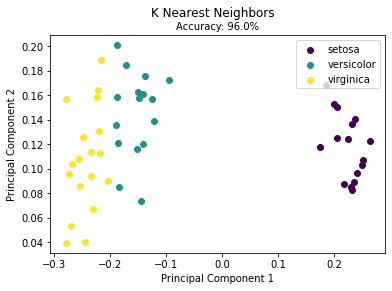

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def normalize(X, axis=-1, order=2):
    """Normalise the dataset (unit norm)
        Axis:0 => Each feature(column) is normalised to unit norm
        Axis:1 => Each sample(row) is normalised to unit norm
        X = X / sqrt(sum|X|^2)
    """
    norm = np.atleast_1d(np.linalg.norm(X, ord=order, axis=axis))
    norm[norm == 0] = 1
    return X / np.expand_dims(norm, axis=axis)

data = datasets.load_iris()
X = normalize(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = KNNClassifier(k=5)
y_pred = clf.predict(X_test, X_train, y_train)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

# Reduce dimensions to 2d using pca and plot the results
Plot().plot_in_2d(X_test, y_pred, title="K Nearest Neighbors", accuracy=accuracy, legend_labels=data.target_names)

In [8]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()